In [1]:
# Portfolio Optimization under Fat Tails (Mandelbrot-Inspired CVaR)

Development of an alternative portfolio optimization model, based on the Mandelbrot proposal, that takes into account the non-Gaussian nature of returns and the presence of more frequent extreme events than expected under classical hypotheses.

The results and visualizations will be analyzed.

The chosen stocks are from the technology industry.



In [2]:

# IMPORT LIBRARIES

# Use 'yfinance' library to daownload historical data from Yahoo Finance.

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t



In [3]:
# Download data (5 years) from 2020-10-01 to 2023-12-31.

tickers = ['AAPL', 'TSLA', 'NVDA', 'AMD', 'META', 'AMZN']
data = yf.download(tickers, start="2020-01-01", end="2024-12-31")['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  6 of 6 completed


In [4]:
# Calculating daily logarithmic returns
returns = np.log(data / data.shift(1)).dropna()

In [5]:
# SIMULATION PARAMETERS

# Number of random portfolios to simulate
num_portfolios = 10000

# Confidence level for CVaR
confidence_level = 0.95

# Degrees of freedom for the t distribution (heavy tail)
degrees_freedom = 3

In [6]:
# STRUCTURE TO SAVE RESULTS

# Return: Expected return of each portfolio
# CVar: Conditional Value at Risk of the portfolio (extreme risk)
# Weights: Weights assigned to each asset in the portfolio

results = {'Return': [],'CVaR': [],'Weights': []}

In [7]:

# Mean - daily returns per asset
mean_returns = returns.mean()

# Covariance - matrix of daily returns
cov_matrix = returns.cov()

In [12]:
mean_returns

,0
Ticker,
AAPL,0.000989
AMD,0.000728
AMZN,0.000674
META,0.000828
NVDA,0.002497
TSLA,0.002132


In [13]:
cov_matrix

Ticker,AAPL,AMD,AMZN,META,NVDA,TSLA
Ticker,,,,,,
AAPL,0.000398,0.000373,0.000269,0.000320,0.000413,0.000415
AMD,0.000373,0.001089,0.000412,0.000465,0.000835,0.000622
AMZN,0.000269,0.000412,0.000513,0.000393,0.000448,0.000417
META,0.000320,0.000465,0.000393,0.000819,0.000516,0.000403
NVDA,0.000413,0.000835,0.000448,0.000516,0.001137,0.000678
TSLA,0.000415,0.000622,0.000417,0.000403,0.000678,0.001782


In [8]:
# Function to calculate CVaR with t-distribution.

def calculate_cvar_t(portfolio_returns, alpha=confidence_level, df=degrees_freedom):

    # Calculates the CVaR (Expected Shortfall) from a simulated return with t distribution.

    sorted_returns = np.sort(portfolio_returns)
    var_index = int((1 - alpha) * len(sorted_returns))
    cvar = -sorted_returns[:var_index].mean()
    return cvar

In [9]:
# Random portfolio simulation

for _ in range(num_portfolios):
  # Random weights
    weights = np.random.random(len(tickers))

  # Normalization: sum of weights = 1 (fully inverted portfolio)
    weights /= np.sum(weights)

  # Expected return of the portfolio
    portfolio_return = np.sum(mean_returns * weights)

  # Estimated volatility
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Simulation of 1,000 daily returns using a heavy-tailed t-distribution
    # Montecarlo Simulation
    simulated_returns = t.rvs(df=degrees_freedom, size=1000) * portfolio_vol + portfolio_return

    # Calculate CVaR using the function defined above
    cvar = calculate_cvar_t(simulated_returns, alpha=confidence_level, df=degrees_freedom)

    # Save results
    results['Return'].append(portfolio_return)
    results['CVaR'].append(cvar)
    results['Weights'].append(weights)

In [10]:
# Final dataframe creation

portfolios = pd.DataFrame(results)

In [11]:
portfolios.head()

,Return,CVaR,Weights
0,0.001562,0.095318,"[0.1673972612129915, 0.19751234949032784, 0.05..."
1,0.001050,0.089840,"[0.0281078318519411, 0.15529592813738136, 0.42..."
2,0.001472,0.089181,"[0.07730419593872295, 0.002326806669440618, 0...."
3,0.001172,0.084711,"[0.1702874085800864, 0.1958918558937836, 0.204..."
4,0.001476,0.091846,"[0.0794629644818173, 0.11965080794870377, 0.14..."


In [14]:
# Optimal portfolio determination

# Maximize the extreme risk-adjusted ratio: Expected Return / CVaR

optimal_idx = portfolios['Return'] / portfolios['CVaR']
optimal_portfolio = portfolios.loc[optimal_idx.idxmax()]

Text(0.5, 1.0, 'Fractal Portfolio Optimization – Inspired by Mandelbrot')

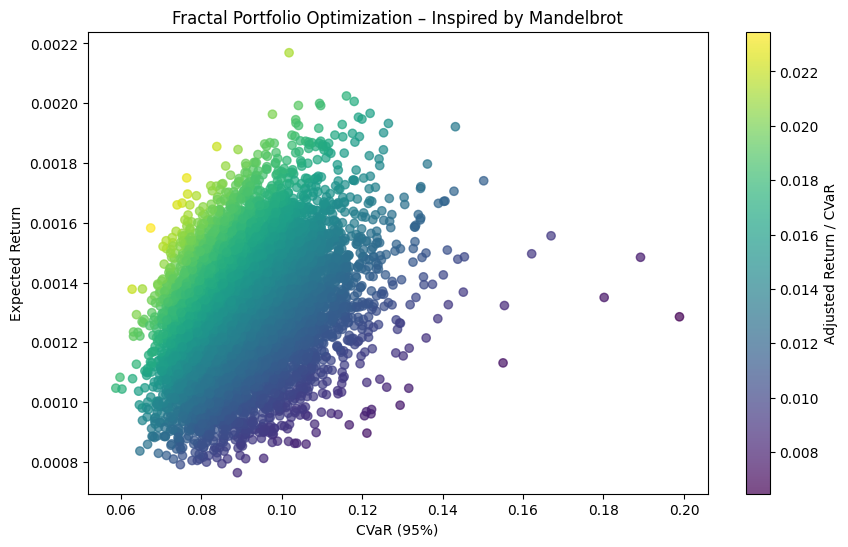

In [15]:
# RESULTS VISUALIZATION

plt.figure(figsize=(10, 6))
plt.scatter(portfolios['CVaR'], portfolios['Return'], c=optimal_idx, cmap='viridis', alpha=0.7)
plt.colorbar(label='Adjusted Return / CVaR')  # Most attractive portfolios according to the adjusted ratio
plt.xlabel('CVaR (95%)')
plt.ylabel('Expected Return')
plt.title('Fractal Portfolio Optimization – Inspired by Mandelbrot')



This chart is a visual representation of the 10,000 simulated portfolios, each with a different combination of weights among technology assets (AAPL, TSLA, NVDA, etc.), using the Mandelbrot fractal approach. Let's break it down:

X-axis:
CVaR (95%): This is the portfolio's extreme risk, measured as the average loss in the worst 5% of cases.
The further to the right, the more extreme risk the portfolio has.

Y-axis:
Expected Return: This is the portfolio's expected daily return.
The higher the value, the more profitable the portfolio is on average.

The colors represent the Adjusted Return/CVaR, i.e., how good the relationship between expected return and extreme risk is.
Lighter colors (yellow): portfolios with a better ratio, high returns with little extreme risk.
Darker colors (blue or purple): worse relationships, low returns, or high risk.

**ANALYSIS:**

There are portfolios that offer good returns without exposing themselves to so much extreme risk.
This contradicts the intuition that to achieve higher returns, one must assume more risk.

Many portfolios are concentrated between CVaR 0.065–0.11 and return 0.0009–0.0016, which shows a zone of efficiency.
The best portfolios (yellow) are on the left and above—decent returns, with very low CVaR.

Instead of using standard deviation as a proxy for risk, CVaR was used and returns were simulated with a Student's t distribution (df=3), inspired by the Mandelbrot fractal market hypothesis. Thus, portfolios with better performance adjusted for extreme events were identified.


In [16]:
# Print expected return and CVaR of the optimal portfolio
print(f"🔴 Optimal Portfolio Coordinates:")
print(f"Expected Return: {optimal_portfolio['Return']:.6f}")
print(f"CVaR (95%): {optimal_portfolio['CVaR']:.6f}")

🔴 Optimal Portfolio Coordinates:
Expected Return: 0.001582
CVaR (95%): 0.067448


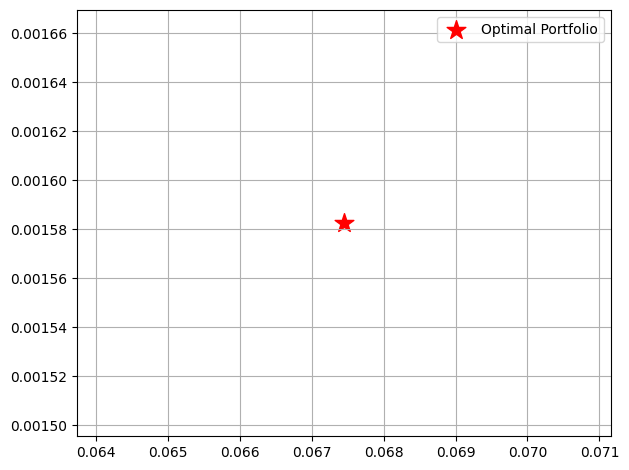

In [17]:
# The optimal portfolio is marked with a red star.
plt.scatter(optimal_portfolio['CVaR'], optimal_portfolio['Return'], color='red', marker='*', s=200, label='Optimal Portfolio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The point has coordinates:
X ≈ 0.067 → CVaR (extreme portfolio risk)
Y ≈ 0.00158 → expected daily return

About this portfolio:
It has a competitive return (≈ 0.158% daily).
It has a low CVaR (≈ 6.7%) compared to other simulated portfolios.
The return-to-extreme risk ratio is the highest of all the simulated portfolios.

This portfolio is ideal for an investment strategy in which:

- The investor seeks protection against extreme events.
- Seeks efficiency in highly volatile environments.
- Is looking to preserve capital without sacrificing too much return.

Using a Monte Carlo simulation with a Student's t-distribution (df=3), the asset allocation was optimized by maximizing the CVaR-adjusted return (rather than the standard deviation). This allowed us to identify a portfolio that is robust to extreme events, aligned with Mandelbrot's fractal vision of financial markets.

In [18]:
# Print the actual weights of the optimal portfolio

In [19]:
weights_df = pd.DataFrame({
    'Asset': tickers,
    'Weight': optimal_portfolio['Weights']
})
print(weights_df)

  Asset    Weight
0  AAPL  0.218636
1  TSLA  0.032771
2  NVDA  0.175821
3   AMD  0.058771
4  META  0.217200
5  AMZN  0.296801


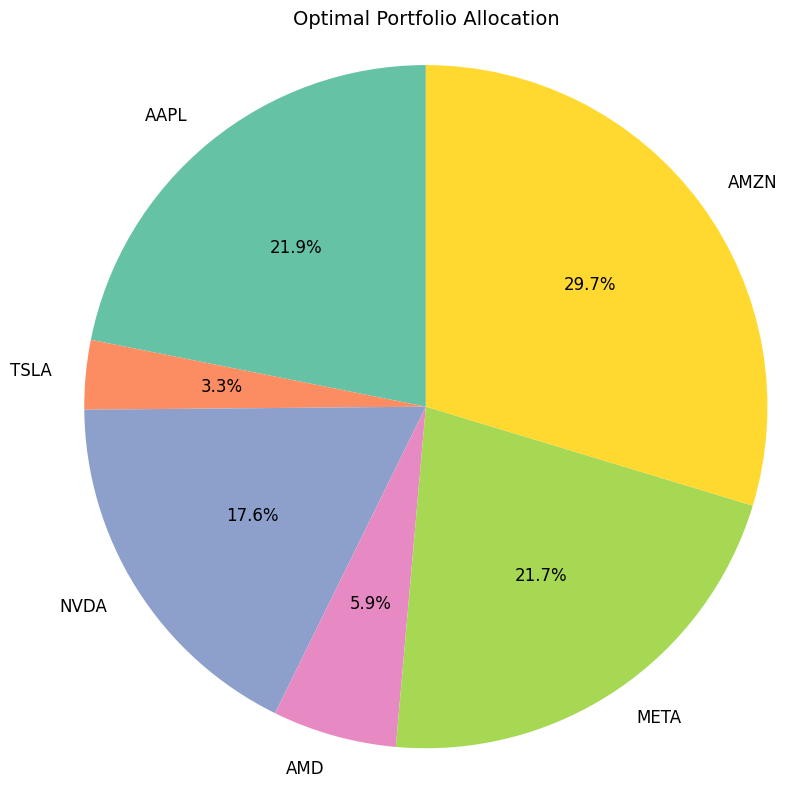

In [20]:
import matplotlib.pyplot as plt

# Actual data
tickers = ['AAPL', 'TSLA', 'NVDA', 'AMD', 'META', 'AMZN']
weights = optimal_portfolio['Weights']

# Graph colors
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(weights, labels=tickers, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 12})
plt.title('Optimal Portfolio Allocation', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()